In [1]:
from database import select_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px

from graphmodels.data_utils import data_dict_from_df_tables, get_X_y_from_data
from graphmodels.validation import score_model, plot_diagnostic

plt.style.use('ggplot')

df_tables = ["aquastat", 'worldbank', 'evapotranspiration', 'cropcalendar', 'efficientwater', 'saracrops']


aquastat = select_dataset('aquastat')
wb_data = select_dataset('worldbank')
evapotranspiration = select_dataset('evapotranspiration')
cropcalendar = select_dataset('cropcalendar').drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')
crops = select_dataset('sarahcrops')


aquastat = aquastat[~aquastat.Variable.isin(['CI', 'TC', 'ICA', 'AIR'])]
crops = crops[~crops.Variable.isin(['ICA', 'CI'])]

data_dict = data_dict_from_df_tables([aquastat, wb_data, evapotranspiration, cropcalendar, efficientwater, crops])


def preprocess_dict_item(key, value):
    mux = pd.MultiIndex.from_product([aquastat.ISO.unique(), range(2000, 2020)],
                                 names=['ISO', 'Year'])

    if key in ['ICA', 'Kc']:
        return value
    else:
        return (
              value.reindex(mux)
                  .groupby(level='ISO')
                  .fillna(method='ffill')
                  .groupby(level='ISO')
                  .fillna(method='bfill')
                  .fillna(0) )


data_dict = {k: preprocess_dict_item(k, v) for k, v in data_dict.items()}


In [9]:
data_dict['AIR']

ISO  Year
AFG  2000    2140.0
     2001    2140.0
     2002    1745.0
     2003    2752.0
     2004    2086.0
              ...  
VIR  2015       0.0
     2016       0.0
     2017       0.0
     2018       0.0
     2019       0.0
Name: AIR, Length: 4240, dtype: float64

In [2]:
data_dict['ICA'].loc['AFG']

Item
barley         116.0
cotton          33.0
fruit          137.0
grapes          61.0
maize          183.0
potatoes        15.0
pulses          27.0
rice           208.0
sesame          10.0
sugar beet       2.0
sugarcane        2.0
sunflower       10.0
vegetables      69.0
wheat         1303.0
Name: ICA, dtype: float64

In [3]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import numpy as np

# Conversions
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3 TO CHECK
mm_to_m = 1e-2  # 1e-3 
mmyear_to_m3year = 1e-2 #  from mm/year to m3/year as 1mm = 10m3/ha \n",

IWW_nodes = {'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor'},
             'ICA': {'type': 'input', 'unit':'1000 ha', 'name': 'Cropland area actually irrigated'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: abs(ETc - ETa) # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Agriculture area actually irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': '1e9 m3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'AWU': {'type': 'variable', 'unit': '1e9 m3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda IWW, **kwargs: IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''

    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }
EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'ICA': {'type': 'input',
                     'unit': '1000 ha',
                     'name': 'Cropland area actually irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'AGVA': {'type': 'input',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$',
                      },

             'CL': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Cropland'},
             'PAIR': {'type': 'variable',
                      'name': 'Proportion of Irrigated Cropland',
                      'unit': '1',
                      'computation': lambda ICA, CL, **kwargs: ICA.groupby(level=['ISO']).sum() / CL
                      },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '1',
                    'computation': lambda PAIR, **kwargs: 1 / (1 + (PAIR / (1 - PAIR) * 0.375))
                    },

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},

             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, AGVA, IGVA, SGVA, Cr, **kwargs: (AGVA * (1 - Cr) + IGVA + SGVA) / (TWW * 1e9)
                     },
             }

EW2_nodes = {
    'IRWR': {'type': 'input',
                     'name': 'Internal Renewable Water Resources',
                     'unit': 'm3/year'},
    'ERWR': {'type': 'input',
             'unit': 'm3/year',
             'name': 'External Renewable Water Resources'},
    'TRF': {'type': 'variable',
            'name': 'Total Renewable Freshwater',
            'unit': 'm3/year',
            'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
            },
    'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
    'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
    'TNCW': {'type': 'variable',
             'name': 'Total Non Conventional Water',
             'unit': 'm3/year',
             'computation': lambda DW, TW, **kwargs: DW + TW
             },
    'TFA': {'type': 'variable',
            'name': 'Total Freshwater Available',
            'unit': 'm3/year',
            'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
            },
    'TWW': {'type': 'input', 'unit': '1e9 m3/year', 'name': 'Total Water Withdrawal'},
    'EFR': {'type': 'parameter',
            'unit': 'm3/year',
            'name': 'Environmental Flow Requirement'},
    'EW2': {'type': 'output',
            'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
            'unit': '%',
            'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR) * 1e2
            },
    'Natural EW2': {'type': 'output',
                    'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                    'unit': '%',
                    'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR) * 1e2
                    }
}

EW1_model = GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes]))
EW_model =  GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes, EW2_nodes]))

In [4]:
X, y = get_X_y_from_data(EW1_model, data_dict)
res = EW1_model.run(X)

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
X, y = get_X_y_from_data(EW1_model, data_dict)
res = EW1_model.run(X)
print(score_model(EW1_model, X, y))

IWR
IWW
AWU
MWU
TWW
EW1
         r2  correlation        rmse Variable
0  0.673832     0.959427   49.031668      IWR
1 -0.137856     0.345620  194.301120      IWW
2  0.625183     0.930965  193.370224      AWU
3  0.868318     0.937490    0.964228      MWU
4  0.710473     0.939077  209.338453      TWW
5  0.739366     0.860135  942.307315      EW1


<AxesSubplot:xlabel='Year', ylabel='EW1'>

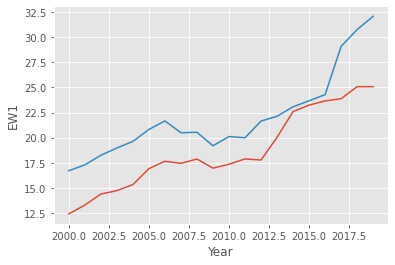

In [12]:
sns.lineplot(data=y['EW1'].loc['HUN'])
sns.lineplot(data=res['EW1'].loc['HUN'])

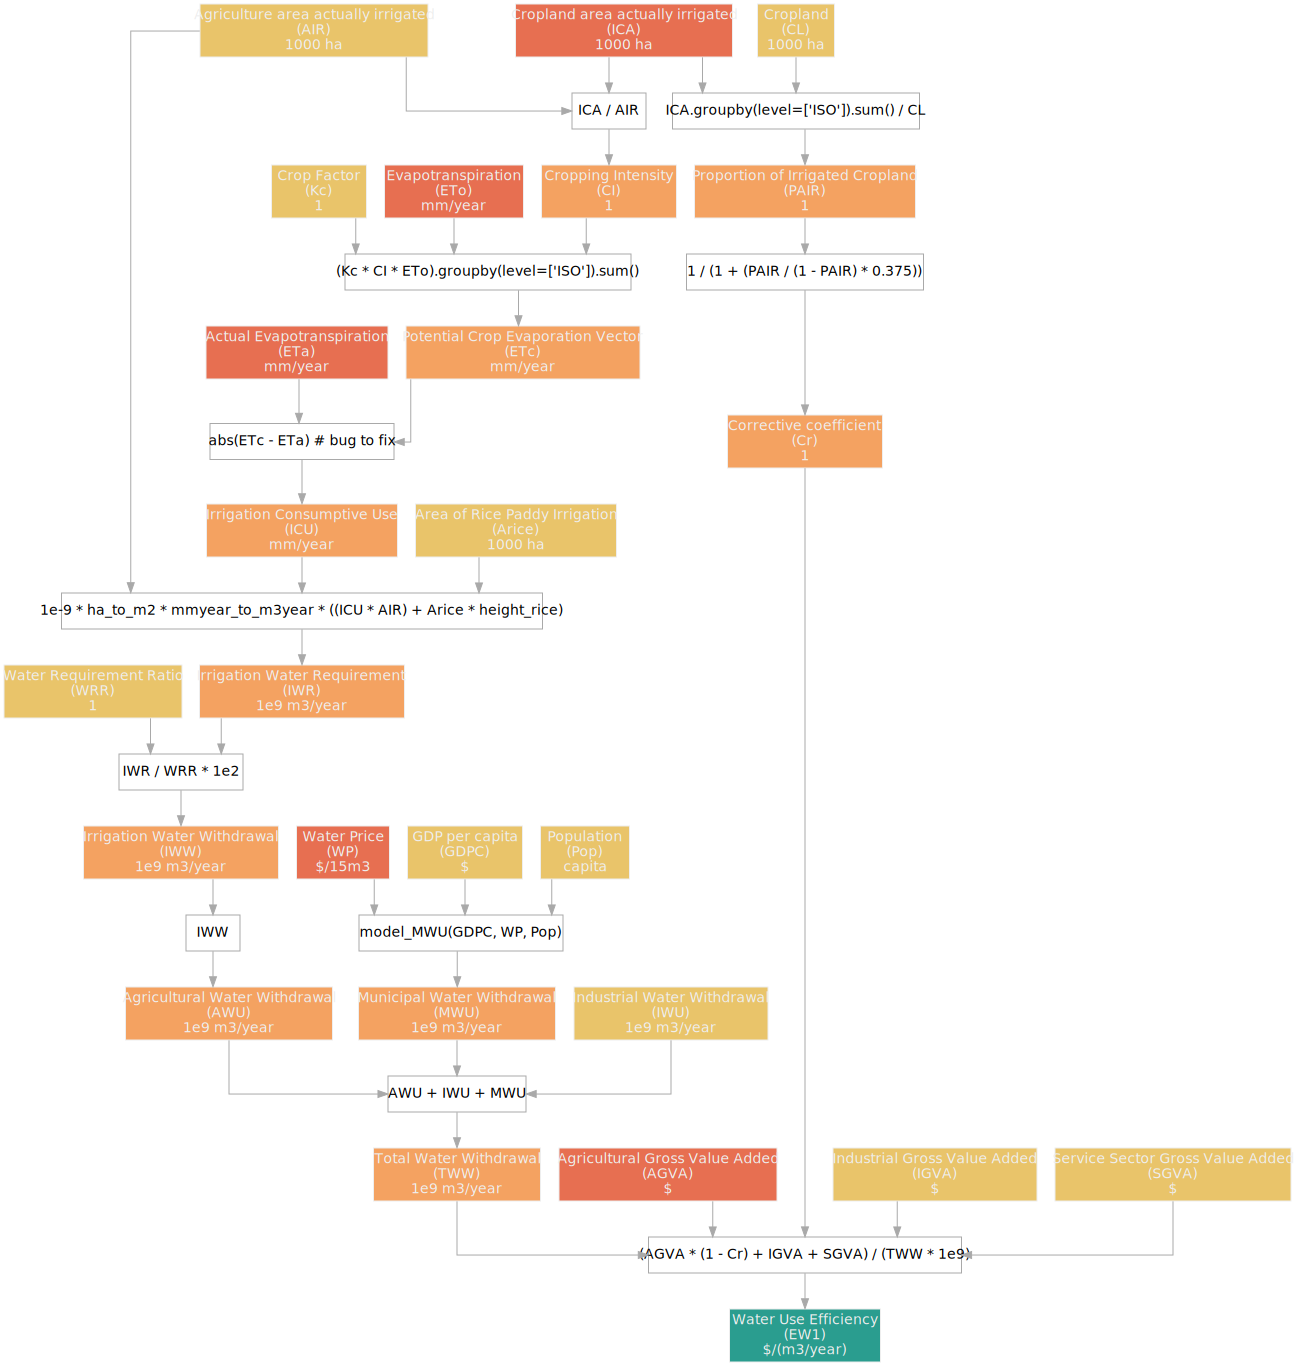

In [77]:
EW1_model.draw()

In [16]:
import pandas as pd
from database import select_dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px

# FIND WAY TO WRAP THIS CLEANLY CAUSE IT's A MESS !

aquastat = select_dataset('aquastat').dropna().drop(columns=['Area'])
aquastat = aquastat[~aquastat.ISO.isin(['USA', 'CHN', 'IND', 'RUS'])] # Not parsed !
aquastat = aquastat[~aquastat.Variable.isin(['CI', 'TC', 'ICA', 'AIR'])]
aquastat['Year'] = aquastat['Year'].astype(int)

evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar')#.drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')
wb_data = select_dataset('worldbank')
wb_data['Year'] = wb_data['Year'].astype(int)

crops = select_dataset('sarahcrops').replace('TC', 'CL')

crops = crops[~crops.Variable.isin(['ICA'])]
#cropcalendar = cropcalendar[~cropcalendar.Variable.isin(['ICA'])]

MWU_df = pd.concat([aquastat, evapotranspiration, cropcalendar, efficientwater, wb_data, crops])
MWU_df = MWU_df[~MWU_df.Variable.isin(['CI'])]


MWU_df.to_csv('outputs/MWU_df.csv', index=False)

#MWU_df = MWU_df.query("Year >= 2000")
MWU_df.to_csv('outputs/MWU_df.csv', index=False)

In [17]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np
from graphmodels.validation import score_model, plot_diagnostic
from models.Sarah.model_EW import EW_models, MWU_model
from graphmodels.utils import get_X_y_from_data

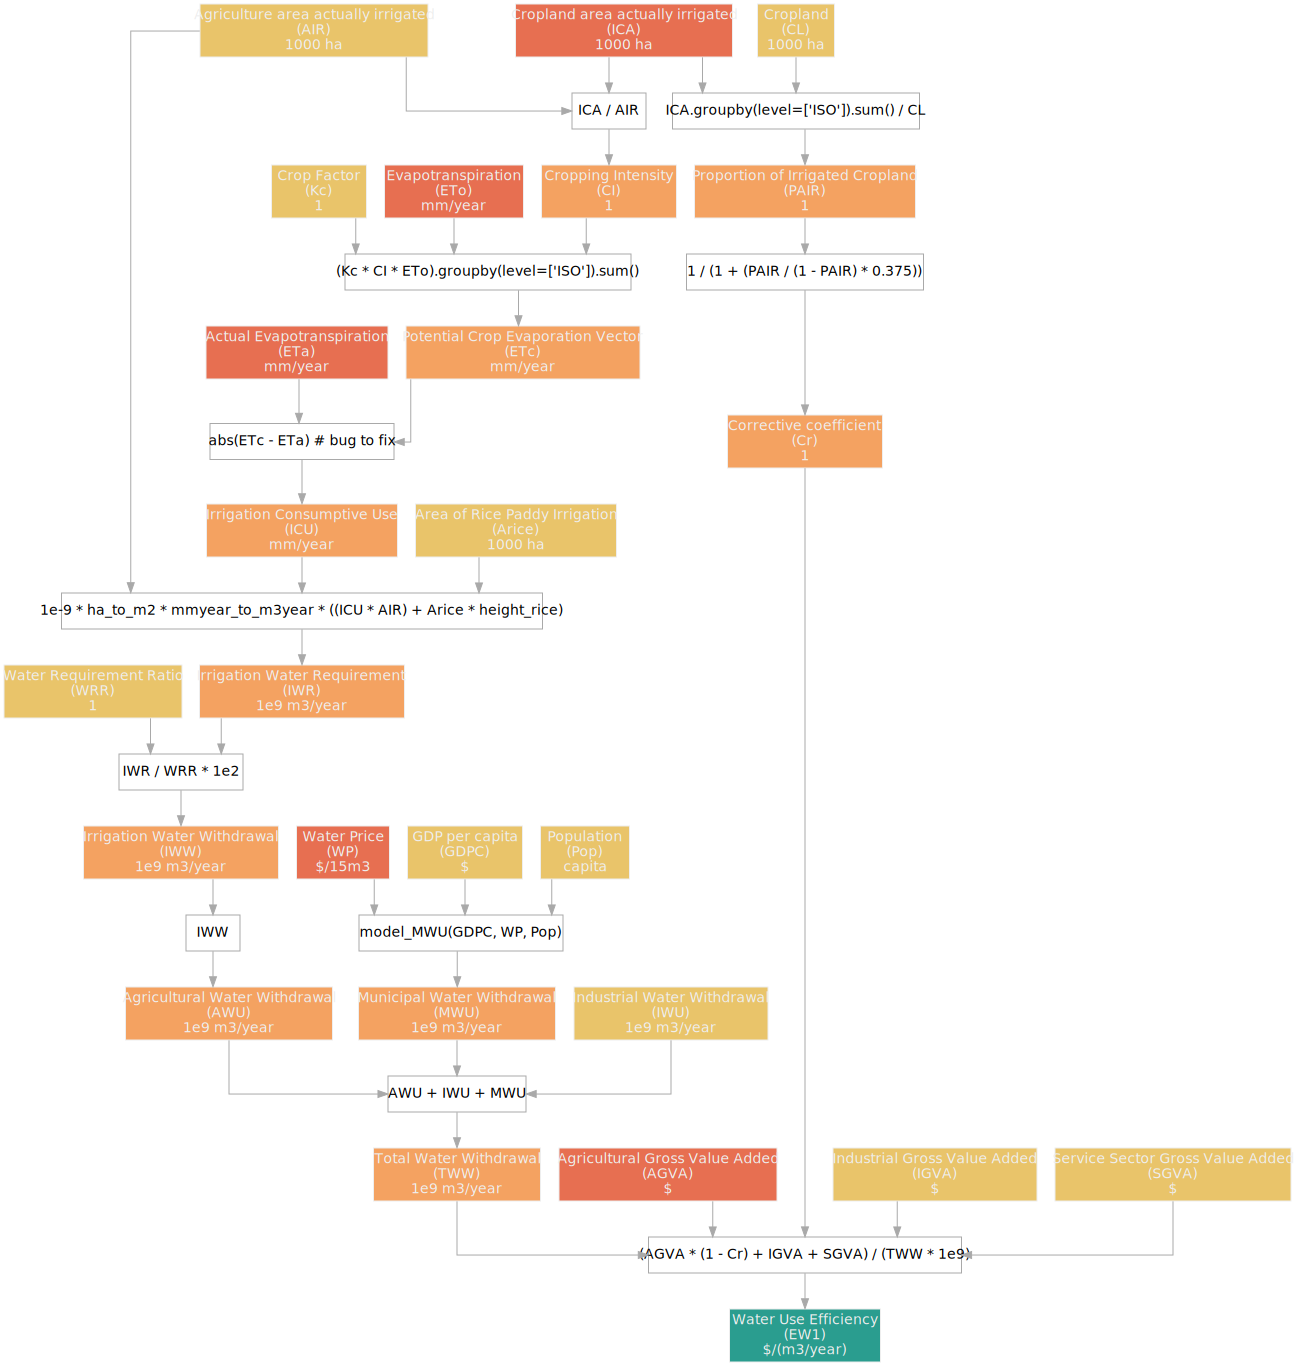

In [18]:
def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    item_df = df[df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')

    data_dict.update(df_to_dict(non_item_df))
    data_dict.update(df_to_dict(item_df))

    return data_dict


from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import numpy as np

# Conversions
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3
mm_to_m = 1  # 1e-3 TO CHECK
mmyear_to_m3year = 1  # from mm/year to m3/year as 1mm = 10m3/ha \n",

IWW_nodes = {'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor'},
             'ICA': {'type': 'input', 'unit': '1000 ha', 'name': 'Cropland area actually irrigated'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: abs(ETc - ETa) # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Agriculture area actually irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': '1e9 m3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'AWU': {'type': 'variable', 'unit': '1e9 m3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda IWW, **kwargs: IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''

    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }
EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'ICA': {'type': 'input',
                     'unit': '1000 ha',
                     'name': 'Cropland area actually irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'AGVA': {'type': 'input',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$',
                      },

             'CL': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Cropland'},
             'PAIR': {'type': 'variable',
                      'name': 'Proportion of Irrigated Cropland',
                      'unit': '1',
                      'computation': lambda ICA, CL, **kwargs: ICA.groupby(level=['ISO']).sum() / CL
                      },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '1',
                    'computation': lambda PAIR, **kwargs: 1 / (1 + (PAIR / (1 - PAIR) * 0.375))
                    },

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},

             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, AGVA, IGVA, SGVA, Cr, **kwargs: (AGVA * (1 - Cr) + IGVA + SGVA) / (TWW * 1e9)
                     },
             }

EW2_nodes = {
    'IRWR': {'type': 'input',
                     'name': 'Internal Renewable Water Resources',
                     'unit': 'm3/year'},
    'ERWR': {'type': 'input',
             'unit': 'm3/year',
             'name': 'External Renewable Water Resources'},
    'TRF': {'type': 'variable',
            'name': 'Total Renewable Freshwater',
            'unit': 'm3/year',
            'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
            },
    'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
    'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
    'TNCW': {'type': 'variable',
             'name': 'Total Non Conventional Water',
             'unit': 'm3/year',
             'computation': lambda DW, TW, **kwargs: DW + TW
             },
    'TFA': {'type': 'variable',
            'name': 'Total Freshwater Available',
            'unit': 'm3/year',
            'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
            },
    'TWW': {'type': 'input', 'unit': '1e9 m3/year', 'name': 'Total Water Withdrawal'},
    'EFR': {'type': 'parameter',
            'unit': 'm3/year',
            'name': 'Environmental Flow Requirement'},
    'EW2': {'type': 'output',
            'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
            'unit': '%',
            'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR) * 1e2
            },
    'Natural EW2': {'type': 'output',
                    'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                    'unit': '%',
                    'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR) * 1e2
                    }
}

EW1_model = GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes]))
EW_model =  GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes, EW2_nodes]))
EW1_model.draw()

In [19]:
data_dict = df_to_data_dict(MWU_df, itemized=['Kc', 'ICA'])

X, y = get_X_y_from_data(EW1_model, data_dict)
res = EW1_model.run(X)
print(score_model(EW1_model, X, y))



/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
IWR
IWW
AWU
MWU
TWW
EW1
          r2  correlation         rmse Variable
0 -10.445159     0.379583  1303.048518      IWR
1  -6.513977     0.239130  1170.067186      IWW
2   0.198792     0.899548   337.729863      AWU
3   0.813218     0.904427     1.011215      MWU
4   0.407680     0.888131   351.954988      TWW
5   0.560649     0.764069  1385.235967      EW1


<AxesSubplot:xlabel='Year', ylabel='EW1'>

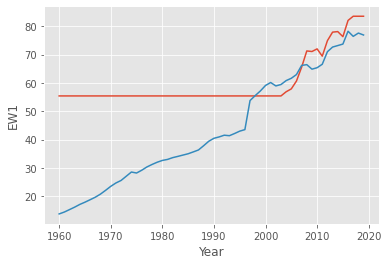

In [20]:
sns.lineplot(data=y['EW1'].loc['FRA'])
sns.lineplot(data=res['EW1'].loc['FRA'])

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
IWR
IWW
AWU
MWU
TWW
TFA
EW1
EW2
          r2  correlation          rmse Variable
0 -10.445159     0.379583   1303.048518      IWR
1  -6.513977     0.239130   1170.067186      IWW
2   0.198792     0.899548    337.729863      AWU
3   0.813218     0.904427      1.011215      MWU
4   0.407680     0.888131    351.954988      TWW
5   0.989367     0.995188   4090.506776      TFA
6   0.560649     0.764069   1385.235967      EW1
7  -0.856685     0.564226  45473.106584      EW2


<AxesSubplot:xlabel='Year', ylabel='EW2'>

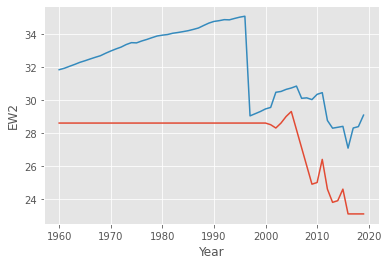

In [21]:
data_dict = df_to_data_dict(MWU_df, itemized=['Kc', 'ICA'])

X, y = get_X_y_from_data(EW_model, data_dict)
res = EW_model.run(X)
print(score_model(EW_model, X, y))

sns.lineplot(data=y['EW2'].loc['FRA'])
sns.lineplot(data=res['EW2'].loc['FRA'])


In [22]:
plot_diagnostic(EW1_model, X, y, 'IWR', hover_data=['ISO', 'Year'])

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
#from graphmodels.utils import df_to_data_dict

df = MWU_df
data_dict = df_to_data_dict(df, ['ICA', 'Kc'])

In [24]:
def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(2000, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index, method='ffill')

def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(2000, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


data_dict_expanded = {}

for key, item in data_dict.items():
    if key not in ['Kc', 'ICA']:
        data_dict_expanded[key] = expand_series_non_itemized(item)

data_dict_expanded['Kc'] = data_dict['Kc']
data_dict_expanded['ICA'] = data_dict['Kc']

In [25]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

def apply_scenario_WP(WP, rate):
    WP = WP.copy()
    for i in range(2020, 2051):
        WP.loc[:, i] = (WP.loc[:, 2019] * rate ** (i - 2019)).values
    return WP


def apply_projection_GVA(GVA):
    GVA = GVA.copy()
    for ISO in GVA.index.get_level_values('ISO').unique():
        fit = Holt(GVA.loc[ISO, 2000:2020].values).fit(smoothing_level=0.3)
        GVA.loc[ISO, 2020:2050] = fit.forecast(31)
       
    return GVA


def apply_projection_AIR(AIR, rate=1.05):
    AIR = AIR.copy()
    for i in range(2020, 2051):
        AIR.loc[:, i] = (AIR.loc[:, 2019] * rate ** (i - 2019)).values
    return AIR

def apply_scenario_WRR(WR, rate=0.9):
    WR = WR.copy()
    for i in range(2020, 2051):
        WR.loc[:, i] = (WR.loc[:, 2019] * rate ** (i - 2019)).values
    return WR

In [26]:
#AGVA_proj = apply_projection_GVA(data_dict_expanded['AGVA'])
#IGVA_proj = apply_projection_GVA(data_dict_expanded['IGVA'])
#SGVA_proj = apply_projection_GVA(data_dict_expanded['SGVA'])
# plt.plot(IGVA_proj.loc['FRA'])bb

In [27]:
data_dict_expanded['IGVA'] = apply_projection_GVA(data_dict_expanded['IGVA'])
data_dict_expanded['AGVA'] = apply_projection_GVA(data_dict_expanded['AGVA'])
data_dict_expanded['SGVA'] = apply_projection_GVA(data_dict_expanded['SGVA'])
data_dict_expanded['GDPC'] = apply_projection_GVA(data_dict_expanded['GDPC'])
data_dict_expanded['AIR'] = apply_projection_AIR(data_dict_expanded['AIR'], rate=1.01)
data_dict_expanded['CL'] = apply_projection_AIR(data_dict_expanded['CL'], rate=1.01)

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site

In [28]:
def scenario_BAU(data_dict_expanded=data_dict_expanded):

    data_dict_expanded = data_dict_expanded.copy()
    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    res = EW_model.run(X)

    return res

def scenario_1(data_dict_expanded=data_dict_expanded):
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=1.1)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=1)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)

def scenario_2(data_dict_expanded=data_dict_expanded):
    
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=1.05)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=1)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)


def scenario(data_dict_expanded=data_dict_expanded, WP_rate=1, WRR_rate=1):
    
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=WP_rate)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=WRR_rate)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)

In [29]:
res_1 = scenario()
res_2 = scenario(WP_rate=1.05, WRR_rate=1)
res_3 = scenario(WP_rate=1.1, WRR_rate=0.999)

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

invalid value encountered in log



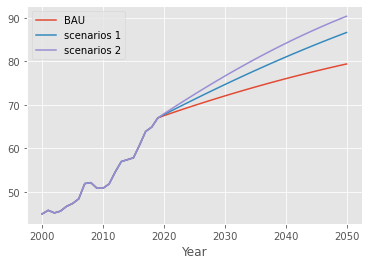

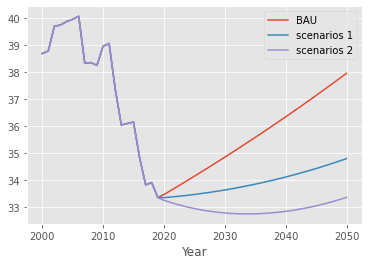

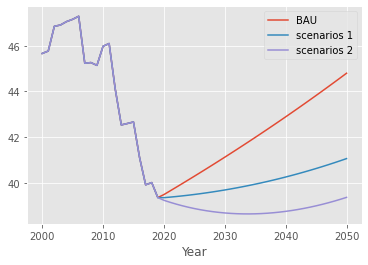

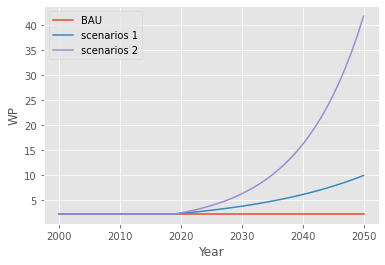

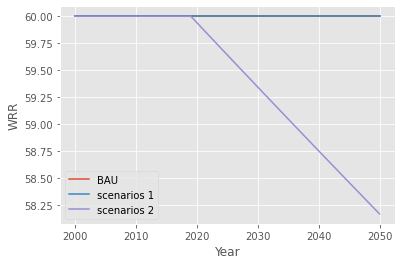

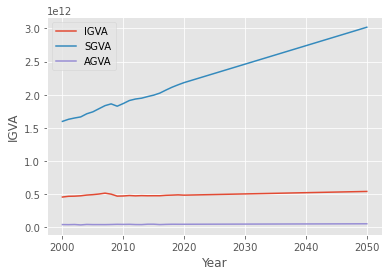

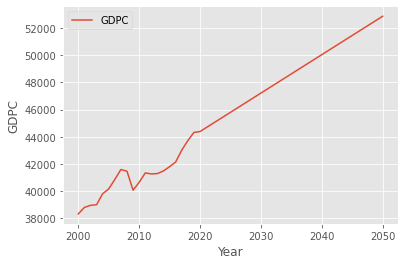

In [30]:
ISO = 'FRA'

def plot_var_scenarios(var, ISO=ISO):
    sns.lineplot(data=res_1[var].loc[ISO], label='BAU')
    sns.lineplot(data=res_2[var].loc[ISO], label='scenarios 1')
    sns.lineplot(data=res_3[var].loc[ISO], label='scenarios 2')
    plt.show()

def plot_context(ISO=ISO):
    sns.lineplot(data=res_1['IGVA'].loc[ISO], label='IGVA')
    sns.lineplot(data=res_1['SGVA'].loc[ISO], label='SGVA')
    sns.lineplot(data=res_1['AGVA'].loc[ISO], label='AGVA')
    plt.show()
    sns.lineplot(data=res_1['GDPC'].loc[ISO], label='GDPC')
    plt.show()


plot_var_scenarios('EW1')
plot_var_scenarios('EW2')
plot_var_scenarios('TWW')
plot_var_scenarios('WP')
plot_var_scenarios('WRR')

plot_context()


# First cleanup for demo

In [1]:
import pandas as pd
MWU_df = pd.read_csv('outputs/MWU_df.csv')

In [2]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import numpy as np

# Conversions
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3
mm_to_m = 1  # 1e-3 TO CHECK
mmyear_to_m3year = 1  # from mm/year to m3/year as 1mm = 10m3/ha \n",

IWW_nodes = {'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor'},
             'ICA': {'type': 'input', 'unit': '1000 ha', 'name': 'Cropland area actually irrigated'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: abs(ETc - ETa) # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Agriculture area actually irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': '1e9 m3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'AWU': {'type': 'variable', 'unit': '1e9 m3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda IWW, **kwargs: IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''

    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }
EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'ICA': {'type': 'input',
                     'unit': '1000 ha',
                     'name': 'Cropland area actually irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'AGVA': {'type': 'input',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$',
                      },

             'CL': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Cropland'},
             'PAIR': {'type': 'variable',
                      'name': 'Proportion of Irrigated Cropland',
                      'unit': '1',
                      'computation': lambda ICA, CL, **kwargs: ICA.groupby(level=['ISO']).sum() / CL
                      },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '1',
                    'computation': lambda PAIR, **kwargs: 1 / (1 + (PAIR / (1 - PAIR) * 0.375))
                    },

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},

             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, AGVA, IGVA, SGVA, Cr, **kwargs: (AGVA * (1 - Cr) + IGVA + SGVA) / (TWW * 1e9)
                     },
             }

EW2_nodes = {
    'IRWR': {'type': 'input',
                     'name': 'Internal Renewable Water Resources',
                     'unit': 'm3/year'},
    'ERWR': {'type': 'input',
             'unit': 'm3/year',
             'name': 'External Renewable Water Resources'},
    'TRF': {'type': 'variable',
            'name': 'Total Renewable Freshwater',
            'unit': 'm3/year',
            'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
            },
    'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
    'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
    'TNCW': {'type': 'variable',
             'name': 'Total Non Conventional Water',
             'unit': 'm3/year',
             'computation': lambda DW, TW, **kwargs: DW + TW
             },
    'TFA': {'type': 'variable',
            'name': 'Total Freshwater Available',
            'unit': 'm3/year',
            'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
            },
    'TWW': {'type': 'input', 'unit': '1e9 m3/year', 'name': 'Total Water Withdrawal'},
    'EFR': {'type': 'parameter',
            'unit': 'm3/year',
            'name': 'Environmental Flow Requirement'},
    'EW2': {'type': 'output',
            'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
            'unit': '%',
            'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR) * 1e2
            },
    'Natural EW2': {'type': 'output',
                    'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                    'unit': '%',
                    'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR) * 1e2
                    }
}

EW_model =  GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes, EW2_nodes]))

In [3]:
def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    item_df = df[df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')

    data_dict.update(df_to_dict(non_item_df))
    data_dict.update(df_to_dict(item_df))

    return data_dict

In [4]:
def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(1980, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index, method='ffill')

def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(1980, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


def expand_data_dict(data_dict):
    data_dict_expanded = {}

    for key, item in data_dict.items():
        if key not in ['Kc', 'ICA']:
            data_dict_expanded[key] = expand_series_non_itemized(item)

    data_dict_expanded['Kc'] = data_dict['Kc']
    data_dict_expanded['ICA'] = data_dict['Kc']

    return data_dict_expanded


def apply_scenario_WP(WP, rate):
    WP = WP.copy()
    for i in range(2020, 2051):
        WP.loc[:, i] = (WP.loc[:, 2019] * rate ** (i - 2019)).values
    return WP


def apply_projection_GVA(GVA):
    GVA = GVA.copy()
    for ISO in GVA.index.get_level_values('ISO').unique():
        fit = Holt(GVA.loc[ISO, 2000:2020].values).fit(smoothing_level=0.3)
        GVA.loc[ISO, 2020:2050] = fit.forecast(31)
       
    return GVA


def apply_projection_AIR(AIR, rate=1.05):
    AIR = AIR.copy()
    for i in range(2020, 2051):
        AIR.loc[:, i] = (AIR.loc[:, 2019] * rate ** (i - 2019)).values
    return AIR

def apply_scenario_WRR(WR, rate=0.9):
    WR = WR.copy()
    for i in range(2020, 2051):
        WR.loc[:, i] = (WR.loc[:, 2019] * rate ** (i - 2019)).values
    return WR

In [5]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


def apply_projection(data_dict_expanded):
    data_dict_expanded['IGVA'] = apply_projection_GVA(data_dict_expanded['IGVA'])
    data_dict_expanded['AGVA'] = apply_projection_GVA(data_dict_expanded['AGVA'])
    data_dict_expanded['SGVA'] = apply_projection_GVA(data_dict_expanded['SGVA'])
    data_dict_expanded['GDPC'] = apply_projection_GVA(data_dict_expanded['GDPC'])
    data_dict_expanded['AIR'] = apply_projection_AIR(data_dict_expanded['AIR'], rate=1.01)
    data_dict_expanded['CL'] = apply_projection_AIR(data_dict_expanded['CL'], rate=1.01)

    return data_dict_expanded

In [6]:
data_dict = df_to_data_dict(MWU_df, ['ICA', 'Kc'])
data_dict_expanded = expand_data_dict(data_dict)
data_dict_expanded = apply_projection(data_dict_expanded)

ConvergenceWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py

In [7]:
data_dict_expanded = {key.split('.')[0]: pd.read_csv(f"outputs/projection_data/{key.split('.')[0]}.csv", index_col=['ISO', 'Year']).iloc[:, 0] for key in os.listdir('outputs/projection_data')}

data_dict_expanded['ICA'] = pd.read_csv('outputs/projection_data/ICA.csv', index_col=['ISO', 'Year', 'Item']).iloc[:, 0]
data_dict_expanded['Kc'] = pd.read_csv('outputs/projection_data/Kc.csv', index_col=['ISO', 'Year', 'Item']).iloc[:, 0]

In [8]:
def scenario_BAU(data_dict_expanded=data_dict_expanded):

    data_dict_expanded = data_dict_expanded.copy()
    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    res = EW_model.run(X)

    return res

def scenario_1(data_dict_expanded=data_dict_expanded):
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=1.1)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=1)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)

def scenario_2(data_dict_expanded=data_dict_expanded):
    
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=1.05)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=1)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)


def scenario(data_dict_expanded=data_dict_expanded, WP_rate=1, WRR_rate=1):
    
        
    data_dict_expanded = data_dict_expanded.copy()
    data_dict_expanded['WP'] = apply_scenario_WP(data_dict_expanded['WP'], rate=WP_rate)
    data_dict_expanded['WRR'] = apply_scenario_WRR(data_dict_expanded['WRR'], rate=WRR_rate)

    X, y = get_X_y_from_data(EW_model, data_dict_expanded)
    return EW_model.run(X)

In [9]:
res_1 = scenario()
res_2 = scenario(WP_rate=1, WRR_rate=1.1)
res_3 = scenario(WP_rate=1, WRR_rate=0.9)


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


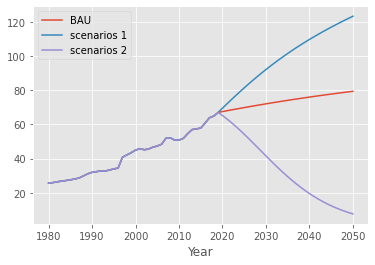

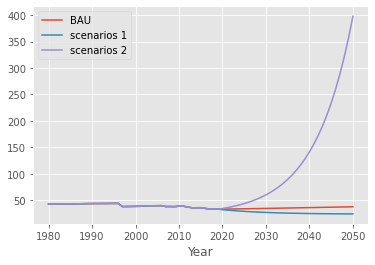

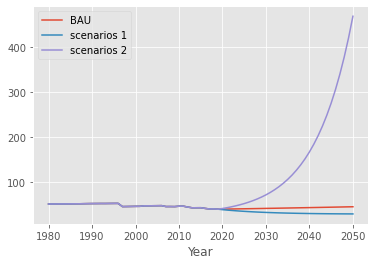

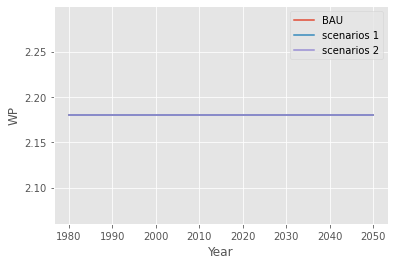

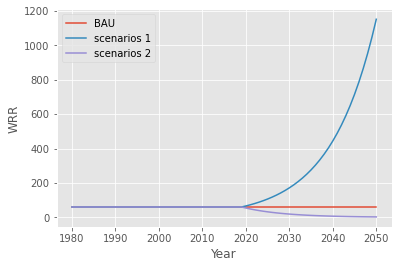

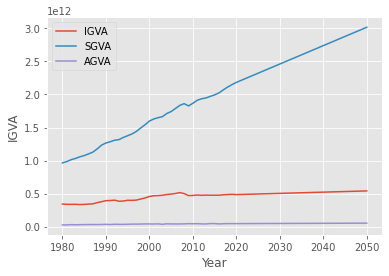

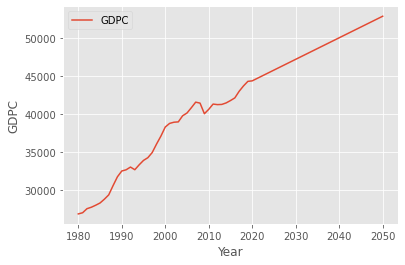

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

ISO = 'FRA'

def plot_var_scenarios(var, ISO=ISO):
    sns.lineplot(data=res_1[var].loc[ISO], label='BAU')
    sns.lineplot(data=res_2[var].loc[ISO], label='scenarios 1')
    sns.lineplot(data=res_3[var].loc[ISO], label='scenarios 2')
    plt.show()

def plot_context(ISO=ISO):
    sns.lineplot(data=res_1['IGVA'].loc[ISO], label='IGVA')
    sns.lineplot(data=res_1['SGVA'].loc[ISO], label='SGVA')
    sns.lineplot(data=res_1['AGVA'].loc[ISO], label='AGVA')
    plt.show()
    sns.lineplot(data=res_1['GDPC'].loc[ISO], label='GDPC')
    plt.show()


plot_var_scenarios('EW1')
plot_var_scenarios('EW2')
plot_var_scenarios('TWW')
plot_var_scenarios('WP')
plot_var_scenarios('WRR')

plot_context()


In [11]:
scenarios_results = {}
scenarios_results['BAU'] = res_1
scenarios_results['scenario_1'] = res_2
scenarios_results['scenario_2'] = res_3

In [14]:
import plotly.express as px

In [15]:
def make_var_df(var, scenarios_results=scenarios_results):
    dfs = []
    for scenario, res_dict in scenarios_results.items():
        dfs.append(res_dict[var].to_frame(name=var).assign(scenario=scenario))
    return pd.concat(dfs, axis=0)


In [16]:
test_df = make_var_df('EW1').reset_index()
px.line(test_df.query("ISO == 'FRA'"), x='Year', y='EW1', color='scenario')

In [20]:
test_df = make_var_df('WRR').reset_index()
px.line(test_df.query("ISO == 'FRA'"), x='Year', y='WRR', color='scenario')

In [21]:
A = {'A': 2, 'B': 3}

In [22]:
A.update({"C": 18})

In [23]:
A

{'A': 2, 'B': 3, 'C': 18}